# <font style="color:blue">Semantic Segmentation</font>

In this notebook, we will create a pipeline for semantic segmentation tasks:

1. Start by creating a dataset class
2. Next, closely examine the evaluation metrics to-learn which loss functions are preferred for this task
3. Finally, train a model, putting all of this together


As always, first, import all the required modules.

In [ ]:
pip install gitpython 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 181 kB 14.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [ ]:
pip install -U git+https://github.com/albumentations-team/albumentations 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ak80znln
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ak80znln
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.0-py3-none-any.whl size=114151 sha256=2cc81267d2cdedf14241415f7f01b7048a1fe9a7b410102fdbc5d085ebbc2eb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-609ki263/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-d21001fc.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [ ]:
pip install opencv-python-headless==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 1.3 MB/s 


In [ ]:
pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.9 MB/s 
     |████████████████████████████████| 58 kB 7.3 MB/s 
     |████████████████████████████████| 376 kB 78.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=838576fc1bc3e7b89772ad462d289072642f2c7db996eba7ed7cd77f9c8489a6
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=77914242cb088cbe04eee9d02b03faf587f27e4c2bb60b9a9c5ba675b6224e72
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import segmentation_models_pytorch as smp
# module for working with operating system
from NewMetric import AJI, F1
import os
# module for fetching item from its operand
from operator import itemgetter
from google.colab import drive

# opencv library
import cv2
# computational library
import numpy as np
# pytorch imports
import torch
# import primitives to build our custom model
import torch.nn as nn
# optimizer
import torch.optim as optim
# visualization library
import matplotlib.pyplot as plt  # pylint: disable=unused-import
# model zoo with pretrained models
import torchvision.models as models
# some extended pytorch primitives
import torch.nn.functional as F

# pretty progress bar
from tqdm.auto import tqdm  # pylint: disable=unused-import
# augmentation imports
from albumentations import Resize, Compose, Normalize, RandomCrop, HorizontalFlip, ShiftScaleRotate, HueSaturationValue
from torch.utils.data import Dataset, DataLoader

from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import MultiStepLR

# generic Trainer class imports
from trainer import Trainer

#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.util.shape import view_as_windows


from utils3 import (  # pylint: disable=unused-import
    setup_system,
    patch_configs,
    download_git_folder,
    get_camvid_dataset_parameters,
    draw_semantic_segmentation_batch,
    draw_semantic_segmentation_samples,
    init_semantic_segmentation_dataset,
    patches,
    patches_test,
)
import utils3
import hooks
from base_metric import BaseMetric
from configuration import SystemConfig, DatasetConfig, TrainerConfig, OptimizerConfig, DataloaderConfig
from matplotlib_visualizer import MatplotlibVisualizer
from torchsummary import summary 
from torchvision import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font style="color:green">1.  Dataset</font>

## <font style="color:green">1.1. Dataset Class</font>

Let's create the dataset class:

In [ ]:
# dataset class implementation
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            num_classes (int): Number of classes in the dataset.
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            dataset_url (string, optional): url to remote repository containing the dataset.
            dataset_folder (string, optional): Folder containing the dataset (related to the git repo).

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder
            
            Names of images in the images_folder and masks_folder should match the same sample.

    """
    def __init__(
        self,
        data_path,
        images_folder,
        masks_folder,
        num_classes,
        transforms=None,
        class_names=None,
        dataset_url=None,
        dataset_folder=None
    ):

        self.num_classes = num_classes
        self.transforms = transforms
        self.class_names = class_names
        # check whether dataset loading parameters exist
        if not os.path.isdir(data_path) and dataset_url is not None and dataset_folder is not None:
            # download CamVid dataset to the predefined directory
            download_git_folder(dataset_url, dataset_folder, data_path)
        # get the map of image-mask pairs
        self.dataset = init_semantic_segmentation_dataset2(data_path, images_folder, masks_folder)

    def get_num_classes(self):
        """Get number of classes in the dataset"""
        return self.num_classes

    def get_class_name(self, idx):
        """
            Get a specific class name

            Arguments:
                idx (int): index of specific class.

            Returns:
                If class_names are available and idx < number of classes,
                returns a specific class name, else returns an empty string.
        """
        class_name = ""
        if self.class_names is not None and idx < len(self.num_classes):
            class_name = self.class_names[idx]
        return class_name

    # get dataset's length
    def __len__(self):
        return len(self.dataset)

    # get item by index
    def __getitem__(self, idx):
        mask=cv2.imread(self.dataset[idx]["mask"], 0)
        mask=np.asarray(mask>0,'int')
        sample = {
            "image": cv2.imread(self.dataset[idx]["image"])[..., ::-1],
            "mask": mask
        }
        # apply transforms to a sample
        if self.transforms is not None:
            sample = self.transforms(**sample)
            sample["mask"] = sample["mask"].long()
        return sample

In [ ]:
class SemSegDataset2(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            num_classes (int): Number of classes in the dataset.
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            dataset_url (string, optional): url to remote repository containing the dataset.
            dataset_folder (string, optional): Folder containing the dataset (related to the git repo).
            train: for sliding window  of MoNuSeg dataset of window size = 126 not 256
            Aug: just for change how to read augmented images and augmented masks

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder
            
            Names of images in the images_folder and masks_folder should match the same sample.

    """
    def __init__(
        self,
        data_path,
        images_folder,
        masks_folder,
        num_classes,
        transforms=None,
        class_names=None,
        dataset_url=None,
        dataset_folder=None,
        im_width=1000,
        im_height=1000,
        train= True,
        Aug= False
    ):
       
        self.num_classes = num_classes
        self.transforms = transforms
        self.class_names = class_names
        self.im_width=im_width
        self.im_height=im_height
        # check whether dataset loading parameters exist
        if not os.path.isdir(data_path) and dataset_url is not None and dataset_folder is not None:
            # download CamVid dataset to the predefined directory
            download_git_folder(dataset_url, dataset_folder, data_path)
        # get the map of image-mask pairs
        if train:
          self.dataset = patches(data_path, images_folder, masks_folder,self.im_width,self.im_height,Aug=Aug)
        else:
          self.dataset = patches_test(data_path, images_folder, masks_folder,im_width=self.im_width,im_height=self.im_height)

    
    def get_num_classes(self):
        """Get number of classes in the dataset"""
        return self.num_classes
    
    

    def get_class_name(self, idx):
        """
            Get a specific class name

            Arguments:
                idx (int): index of specific class.

            Returns:
                If class_names are available and idx < number of classes,
                returns a specific class name, else returns an empty string.
        """
        class_name = ""
        if self.class_names is not None and idx < len(self.num_classes):
            class_name = self.class_names[idx]
        return class_name

    # get dataset's length
    def __len__(self):
        return self.dataset[0].shape[0]

     # get item by index
    def __getitem__(self, idx):
        
        mask = self.dataset[1][idx]
        mask = np.asarray(mask > 0,'int')
        
        image = self.dataset[0][idx]
        
        image = np.moveaxis(image, -1, 0)
        #image=image[..., ::-1].copy()
        #mask= mask[..., ::-1].copy()

       
       
        
        sample = {
            "image":image.copy(),
            "mask": mask.copy()
        }
        # note compose transform from albumentation needs image and mask to be in shape of (H, W, C)
        
        if self.transforms is not None:
            sample = self.transforms(**sample)
            sample["mask"] = sample["mask"].long()
        return sample

In [ ]:
loader_test = DataLoader(
            SemSegDataset2(data_path='/content/drive/MyDrive/all_data/MoNuSeg/test',
                      images_folder='images',
                      masks_folder='masks',
                      num_classes=2,
                      
                      
                
                      
                      class_names=['background','nuclei'],
                      train= True,
                      Aug=False
                ),
            
            batch_size=4,
            shuffle=False,
            
            num_workers=2,
            
   
            pin_memory=True
        )
     

In [ ]:
%matplotlib inline
for i in loader_test:
  print(i['image'].shape)
  

torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4,

# <font style="color:green">2. Evaluation Metrics for Semantic Segmentation </font>

Now, assess  which metrics can be applied to evaluate semantic-segmentation solutions.

## <font style="color:green">2.1. Confusion Matrix Estimator</font>

Confusion matrix is a specific table used to describe the performance of the classification model on test data, for which the true values are known. 
- Each row of the matrix represents the instances in the predicted class 
- Each column represents the instances in the actual class (or vice versa).

Based on the  confusion matrix, create more metrics like Intersection over Union.

In [ ]:
# create confusion matrix class
class ConfusionMatrix(BaseMetric):
    """
        Implementation of Confusion Matrix.

        Arguments:
            num_classes (int): number of evaluated classes.
            normalized (bool): if normalized is True then confusion matrix will be normalized.
    """
    def __init__(self, num_classes, normalized=False):
        # init confusion matrix class fields
        self.num_classes = num_classes
        self.normalized = normalized
        self.conf = np.ndarray((num_classes, num_classes), np.int32)
        self.reset()

    def reset(self):
        """
            Reset of the Confusion Matrix.
        """
        self.conf.fill(0)

    def update_value(self, pred, target):
        """
            Add sample to the Confusion Matrix.

            Arguments:
                pred (torch.Tensor() or numpy.ndarray): predicted mask.
                target (torch.Tensor() or numpy.ndarray): ground-truth mask.
        """
        if torch.is_tensor(pred):
            # convert the prediction tensor to numpy array
            pred = pred.detach().cpu().numpy()
        if torch.is_tensor(target):
            # convert the target tensor to numpy array
            target = target.detach().cpu().numpy()
          
        
        
        # get rid of invalid indices
        valid_indices = np.where((target >= 0) & (target < self.num_classes))
        pred = pred[valid_indices]
        target = target[valid_indices]

        

        # calculate confusion matrix value for new predictions
        replace_indices = np.vstack((target.flatten(), pred.flatten())).T
        
        conf, _ = np.histogramdd(
            replace_indices,
            bins=(self.num_classes, self.num_classes),
            range=[(0, self.num_classes), (0, self.num_classes)]
        )
       
        # update confusion matrix value
        self.conf += conf.astype(np.int32)

    def get_metric_value(self):
        """
            Return the Confusion Matrix.

            Returns:
                numpy.ndarray(num_classes, num_classes): confusion matrix.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            # get normalized confusion matrix
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        return self.conf 

## <font style="color:green">2.2. Intersection Over Union Estimator</font>

The `Jaccard index`, also known as `Intersection Over Union` and the `Jaccard similarity coefficient`,
is a statistic used to estimate the similarity and diversity of sample sets. The `Jaccard coefficient` measures similarity between finite sample sets, and is defined as the size of the
intersection divided by the size of the union of the sample sets.

In [ ]:
# create intersection over union class
class IntersectionOverUnion(BaseMetric):
    """
        Implementation of the Intersection over Union metric.

        Arguments:
            num_classes (int): number of evaluated classes.
            reduced_probs (bool): if True, then argmax was applied to the input predictions.
            normalized (bool): if normalized is True, then confusion matrix will be normalized.
            ignore_indices (int or iterable): list of ignored classes indices.
    """
    def __init__(self, num_classes, reduced_probs=False, normalized=False, ignore_indices=None):
        # created a normalized confusion matrix with num_classes
        self.conf_matrix = ConfusionMatrix(num_classes=num_classes, normalized=normalized)
        self.reduced_probs = reduced_probs

        # check whether ignored classes exist
        if ignore_indices is None:
            self.ignore_indices = None
        elif isinstance(ignore_indices, int):
            self.ignore_indices = (ignore_indices, )
        else:
            try:
                self.ignore_indices = tuple(ignore_indices)
            except TypeError:
                raise ValueError("'ignore_indices' must be an int or iterable")

    def reset(self):
        """
            Reset the Confusion Matrix
        """
        self.conf_matrix.reset()

    def update_value(self, pred, target):
        """ Add sample to the Confusion Matrix.

            Arguments:
                pred (torch.Tensor() or numpy.ndarray): predicted mask.
                target (torch.Tensor() or numpy.ndarray): ground-truth mask.
        """
        if not self.reduced_probs:
            pred = pred.argmax(dim=1)
        self.conf_matrix.update_value(pred, target)

    def get_metric_value(self):
        """
            Return mIOU and IOU per class.

            Returns:
                miou (float32): mean intersection over union.
                iou (list): list of intersection over union per class.
        """
        # get confusion matrix value
        conf_matrix = self.conf_matrix.get_metric_value()

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # set column values of ignore classes to 0
            conf_matrix[:, self.ignore_indices] = 0
            # set row values of ignore classes to 0
            conf_matrix[self.ignore_indices, :] = 0

        # get TP, FP and FN values
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # use errstate to handle the case of zero denominator value
        with np.errstate(divide='ignore', invalid='ignore'):
            # calculate iou by its formula
            iou = true_positive / (true_positive + false_positive + false_negative)

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # exclude ignore indices
            iou_valid_cls = np.delete(iou, self.ignore_indices)
            # get mean class iou value ignoring NaN values
            miou = np.nanmean(iou_valid_cls)
        else:
            # get mean class iou value ignoring NaN values
            miou = np.nanmean(iou)
        return {"mean_iou": miou, "iou": iou}

## <font style="color:green">2.3. Compute Intersection Over Union</font>

Let's practise  calculating the metric. Because we add ground-truth values as predicted values, the result should be equal to `1`.

# Self supervision

# <font style="color:green">3. Model for Semantic Segmentation</font>

## <font style="color:green">3.1. Encoder for Semantic Segmentation</font>

Unlike classification, in semantic segmentation we usually use pyramids of multi-scale
features for pixel-wise classification. It's one way to recover the spatial resolution lost in deep layers.
Let's implement a multi-scale encoder using a pretrained ResNet model.

In [ ]:
# create resnet encoder module
class ResNetEncoder(nn.Module):
    """ ResNet encoder.

        Arguments:
            resnet_type (string): type of resnet (all resnet network which exist in torchvision).
            pretrained (bool): if pretrained == True, ImageNet weights will load.
    """
    
    def __init__(self, resnet_type="resnet18", pretrained=False, weights=None):
        super().__init__()
        # get PyTorch ResNet18 as feature extractor
        if weights is not None:
          print("Hello1")
          self.module = getattr(models, resnet_type)(pretrained=pretrained)
          self.module.fc=nn.Linear(512,2)
                 
          path= weights
          self.module.load_state_dict(torch.load(path))
          
          #print(self.module.conv1.state_dict())
        else:
          print("Hello2")
          self.module = getattr(models, resnet_type)(pretrained=pretrained)

    # get output
    def get_channels_out(self):
        """
            Get num channels of output feature pyramid.

            Returns:
                List of num channels for each feature pyramid layer.
        """
        channels_out = []
        for layer in [getattr(self.module, "layer{}".format(i)) for i in range(1, 5)]:
            channels_out.append(self._get_block_size(layer))
        return channels_out[::-1]

    # define forward pass
    def forward(self, x):
        # init PyTorch ResNet18 layers
        # output number of channels = 64
        x = self.module.conv1(x)
        # output number of channels = 64
        x = self.module.bn1(x)
        # output number of channels = 64
        x = self.module.relu(x)
        # output number of channels = 64
        x = self.module.maxpool(x)

        # output number of channels = 64
        l1_output = self.module.layer1(x)
        # output number of channels = 128
        l2_output = self.module.layer2(l1_output)
        # output number of channels = 256
        l3_output = self.module.layer3(l2_output)
        # output number of channels = 512
        l4_output = self.module.layer4(l3_output)

        return l1_output, l2_output, l3_output, l4_output

    # get size of a module
    @staticmethod
    def _get_block_size(module):
        return list(module[-1].modules())[-2].weight.size()[0]

## <font style="color:green">3.2. FPN Decoder for Semantic Segmentation</font>

To aggregate features from different resolutions, we got a simple strategy: make two layers have the same scale and sum them.

In [ ]:
# create connection layers between encoder and decoder blocks
class LateralConnection(nn.Module):
    """
        Lateral connection.

        Arguments:
            channels_in (int): number of input channels.
            channels_out (int): number of output channels.
    """
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # create output number of channels from input
        self.proj = nn.Conv2d(channels_in, channels_out, kernel_size=1)

    # define forward pass
    def forward(self, prev, cur):
        # interpolating the previous feature map
        up = F.interpolate(prev, cur.size()[-2:], mode="nearest")
        # project consistent number of channels
        proj = self.proj(cur)
        # summarize feature maps into one
        return proj + up


# create decoder module
class FPNDecoder(nn.Module):
    """
        Feature Pyramid Decoder.
            Aggregate all feature pyramid layers using lateral connections.

        Arguments:
            channels_in (list): list of input channels for each feature pyramid layer.
            channels_out (int): number of output channels.
    """
    def __init__(self, channels_in, channels_out=256):
        super().__init__()
        # init decoder as a list of modules
        self.module = nn.ModuleList()
        # create lateral connections between encoder and decoder blocks
        # for the last encoder block there is no need for upsampling
        self.module.append(nn.Conv2d(channels_in[0], channels_out, kernel_size=1))
        for i in range(1, len(channels_in)):
            self.module.append(LateralConnection(channels_in[i], channels_out))

    # define forward pass
    def forward(self, x):
        # append outputs after each laternl layer
        output = [self.module[0](x[0])]
        for i in range(1, len(x)):
            output.append(self.module[i](output[i - 1], x[i]))
        return output

## <font style="color:green">3.3. Semantic Segmentation Network Using Encoder-Decoder Architecture</font>

Let's implement an architecture for semantic segmentation using the `encoder-decoder` topology.

In [ ]:
# create semantic segmentation model
class SemanticSegmentation(nn.Module):
    """
        Semantic Segmentation model using Feature Pyramid Network.

        Arguments:
            num_classes (int): number of classes.
            encoder_type (class): type of encoder network.
            channels_out (int): number of channels of the output features.
            final_upsample (bool): if final_upsample is True then final prediction will be upsampled to the 
                                   original resolution.
    """
    def __init__(self, num_classes, encoder_type=ResNetEncoder, channels_out=128, final_upsample=False,weights=None):
        super().__init__()
        # init fields
        self.final_upsample = final_upsample
        self.encoder = encoder_type(weights=weights)
        
        # create decoder
        self.decoder = FPNDecoder(self.encoder.get_channels_out(), channels_out=channels_out)
        # create classifier with num_classes as output
        self.classifier = nn.Sequential(
            nn.Conv2d(channels_out, channels_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
            nn.Conv2d(channels_out, num_classes, kernel_size=1),
        )

    # define forward pass as a sequence of forward passes between all modules
    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder[::-1])
        classifier = self.classifier(decoder[-1])

        # upsample to the input image size if needed
        if self.final_upsample:
            classifier = F.interpolate(classifier, x.size()[-2:], mode="bilinear", align_corners=False)

        # output number of channels is equal to number of dataset classes
        return classifier

#Other models

1-FPN with EfficientNet as an Encoder 

In [ ]:
fpn = smp.FPN("efficientnet-b3", encoder_weights = None)

fpn.segmentation_head = nn.Sequential(nn.Conv2d(128, 3, kernel_size=(3, 3), 
                                       stride=(1, 1), padding=(1, 1)), 
                                       nn.UpsamplingBilinear2d(scale_factor=4.0))

PATH="/content/drive/MyDrive/weights+vis/FPN/Other tasks/Autoencoder/500epochs_MoNuSeg_augmented_data_FPN.pth"
fpn.load_state_dict(torch.load(PATH))
fpn.segmentation_head = nn.Sequential(nn.Conv2d(128, 2, kernel_size=(3, 3), 
                                       stride=(1, 1), padding=(1, 1)), 
                                       nn.UpsamplingBilinear2d(scale_factor=4.0))



#ex=torch.rand([4,3,256,256])
#out=fpn(ex)
#out.shape

Run this cell only if you want to transfer regression weights

In [ ]:
from efficientnet_pytorch import EfficientNet
Regression_model = EfficientNet.from_pretrained('efficientnet-b3')
segmentation_model= smp.FPN(encoder_name="efficientnet-b3", encoder_weights="imagenet", in_channels=3, classes=2)

Regression_model._blocks=segmentation_model.encoder._blocks
Regression_model._fc= nn.Linear(1536, 2)
Regression_model.load_state_dict(torch.load("/content/drive/MyDrive/weights/FPN/Other tasks/Multi-scale/multiscale_FPN_weights.pth"))

segmentation_model.encoder._conv_stem= Regression_model._conv_stem
segmentation_model.encoder._bn0= Regression_model._bn0
segmentation_model.encoder._blocks= Regression_model._blocks
segmentation_model.encoder._conv_head = Regression_model._conv_head
segmentation_model.encoder._bn1 = Regression_model._bn1
segmentation_model.encoder._avg_pooling = Regression_model._avg_pooling
segmentation_model.encoder._dropout = Regression_model._dropout
segmentation_model.encoder._swish = Regression_model._swish
segmentation_model.segmentation_head = nn.Sequential(nn.Conv2d(128, 2, kernel_size=(3, 3), 
                                       stride=(1, 1), padding=(1, 1)), 
                                       nn.UpsamplingBilinear2d(scale_factor=4.0))
fpn=segmentation_model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [ ]:
onesample=next(iter(loader_test))['image'].float()
onesample.shape
output=fpn(onesample)
output.shape


torch.Size([4, 2, 256, 256])

In [ ]:
from efficientnet_pytorch import EfficientNet

class Efficient_Net_relative(nn.Module):
  def __init__(self,aux_logits = False):
      super(Efficient_Net_relative, self).__init__()
      
      self.model = EfficientNet.from_pretrained('efficientnet-b3')
      segmentation_model= smp.FPN(encoder_name="efficientnet-b3", encoder_weights="imagenet", in_channels=3, classes=2)

      self.model._blocks=segmentation_model.encoder._blocks
    
      self.fc6 = nn.Sequential(
        nn.Linear(1536,4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096),
      )
      self.model._fc=self.fc6
      self.fc = nn.Sequential(
        nn.Linear(2*4096,4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    self.model._fc=self.fc6
    output= self.model(x)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

model = Efficient_Net_relative()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/weights/FPN/Other tasks/Relative-positioning/model_64_30_0.0005_1000_30_1.pth"))

<All keys matched successfully>

In [ ]:
segmentation_model= smp.FPN(encoder_name="efficientnet-b3", encoder_weights="imagenet", in_channels=3, classes=2)

segmentation_model.encoder._conv_stem= model.model._conv_stem
segmentation_model.encoder._bn0= model.model._bn0
segmentation_model.encoder._blocks= model.model._blocks
segmentation_model.encoder._conv_head = model.model._conv_head
segmentation_model.encoder._bn1 = model.model._bn1
segmentation_model.encoder._avg_pooling = model.model._avg_pooling
segmentation_model.encoder._dropout = model.model._dropout
segmentation_model.encoder._swish = model.model._swish
segmentation_model.segmentation_head = nn.Sequential(nn.Conv2d(128, 2, kernel_size=(3, 3), 
                                       stride=(1, 1), padding=(1, 1)), 
                                       nn.UpsamplingBilinear2d(scale_factor=4.0))
fpn=segmentation_model

#Other losses

In [ ]:
class LovaszCELoss(nn.Module):

    def __init__(self, ignore_index, weight=[1,1]):
        super().__init__()
        self.ignore_index = ignore_index
        self.weight = weight

    def forward(self, output, target):
        
        lovasz = smp.losses.LovaszLoss(mode="multiclass")
        ce = nn.CrossEntropyLoss(ignore_index=self.ignore_index)
        loss = (self.weight[0] * lovasz(output, target) + self.weight[1] * ce(output, target)) / np.sum(self.weight)

        return loss

# <font style="color:green">4. Train Semantic Segmentation Models</font>

Now we are ready to build the whole pipeline. The only thing left is to choose which loss to use for
our model training.

To simplify our experiments, we'll determine a simple learning rate policy (constant learning rate through all
training time) and train the network for `30-epochs` only. Kepp experimenting with these hyperparameters to improve
resulting metrics.

## <font style="color:green">4.1. Train Model With nn.CrossEntropyLoss</font>

You  already know that the semantic-segmentation problem is nothing but  a pixel-wise classification problem. So why not go for a simple classification pipeline to train our semanti-segmentation model. Let's try.

In [ ]:
# define experiment class
class Experiment:
    def __init__(
        self,
        # init configs
        system_config: SystemConfig = SystemConfig(),
        dataset_config: DatasetConfig = DatasetConfig(),
        dataloader_config: DataloaderConfig = DataloaderConfig(),
        optimizer_config: OptimizerConfig = OptimizerConfig(),
    ):
        # apply system settings
        self.system_config = system_config
        setup_system(system_config)
        # define train dataloader
        self.loader_train = DataLoader(SemSegDataset2(data_path="/content/drive/MyDrive/all_data/MoNuSeg/train/",
                      images_folder='images/',
                      masks_folder='masks/',
                      num_classes=2,
                      
                class_names=['background','nuclei'],im_width=1000,im_height=1000 , train = True, Aug= False
                
            ), 
            batch_size=4,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )

        # define test dataloader
        self.loader_test = DataLoader(
            SemSegDataset2(data_path='/content/drive/MyDrive/all_data/MoNuSeg/test/',
                      images_folder='images',
                      masks_folder='masks',
                      num_classes=2,
                      
                
                      
                      class_names=['background','nuclei'],
                      train= False
                ),
            
            batch_size=4,
            shuffle=False,
            
            num_workers=2,
            
   
            pin_memory=True
        )

        # define model

        self.model= fpn
        #self.model = SemanticSegmentation(
            #num_classes=self.loader_test.dataset.get_num_classes(), final_upsample=True,weights = "/content/weights2c_resnet18.pth"
        #)


        #####for denosing autoencoder
        #self.model= SemanticSegmentation(num_classes=3, final_upsample=True)
        #self.model.load_state_dict(torch.load("/content/drive/MyDrive/visualizations/outputs_of_AE/65_epochs_200samples_MoNuSeg_resnet18.pth"))
        #self.model.classifier[3]= nn.Conv2d(128,2,1,1)
        ############


        # define loss function as cross-entropy loss
        self.loss_fn = LovaszCELoss(ignore_index=self.loader_test.dataset.get_num_classes(), weight=[1,4])

        #self.loss_fn = nn.CrossEntropyLoss(ignore_index=self.loader_test.dataset.get_num_classes())
        # define metrics function as intersection over union
        self.metric_fn = AJI()
        self.metric_fn2=F1()
        # define optimizer and its params
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay
        )
        # define learning rate scheduler
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        # define visualizer
        self.visualizer = MatplotlibVisualizer()

    # run training
    def run(self, trainer_config: TrainerConfig) -> dict:
        # apply system settings
        setup_system(self.system_config)
        # move training to the chosen device
        device = torch.device(trainer_config.device)
        # send data to chosen device
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.to(device)

        # define trainer
        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            metric_fn2=self.metric_fn2,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            data_getter=itemgetter("image"),
            target_getter=itemgetter("mask"),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("AJI"),
            get_key_metric2=itemgetter("F1"),
            visualizer=self.visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        # define hook to run after each epoch
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_semseg)
        # run the training
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

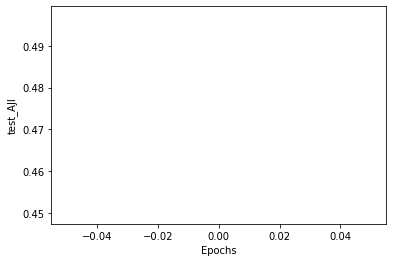

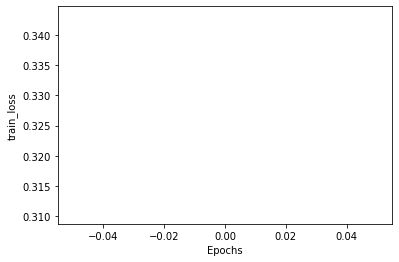

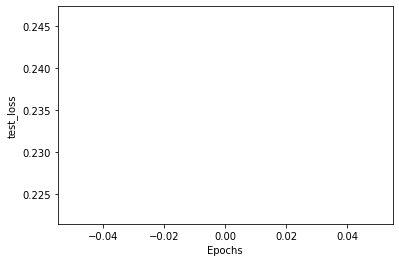

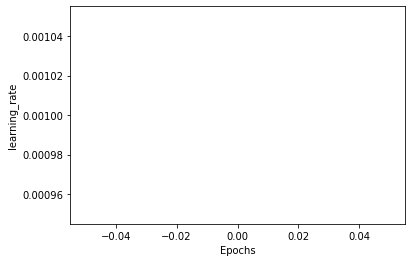

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f920efa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f920efa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f920efa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f920efa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:50<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:50<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f920efa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f920efa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/270 [00:30<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# run the experiment
dataloader_config, trainer_config = patch_configs(epoch_num_to_set=70, batch_size_to_set=16)

optimizer_config = OptimizerConfig(learning_rate=1e-3, lr_step_milestones =[], weight_decay=4e-5)

experiment = Experiment(dataloader_config=dataloader_config, optimizer_config=optimizer_config)

metrics = experiment.run(trainer_config)  


Let's plot the test and train loss curves. Also, we'll plot the test accuracy curve with mean IoU for all classes.

In [ ]:
# create new figure
%matplotlib inline
plt.figure()
# plot test and train loss
plt.plot(metrics["test_loss"], label="test")
plt.plot(metrics["train_loss"], label="train")
plt.legend()
plt.show()

# create new figure
plt.figure()
# plot mean iou metric for all classes
plt.plot([metric['AJI'] for metric in metrics["test_metric"]], label="AJI")
plt.legend()
plt.show()

Let's visualize several test samples and predictions from the network.

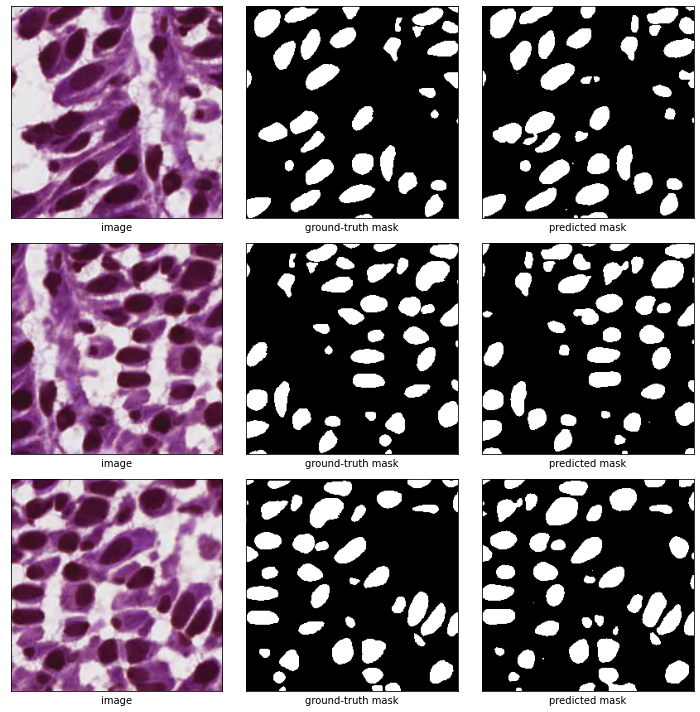

In [ ]:
# get test samples
sample = next(iter(experiment.loader_test))
# get device to run the training on
device = torch.device(trainer_config.device)
# put images on the chosen device
images = sample["image"].to(device)
images=images.float()

# get predictions
preds = experiment.model(images).softmax(dim=1).argmax(dim=1)
# visualize the results
draw_semantic_segmentation_batch(images , sample["mask"], preds)

## <font style="color:green">4.2. Implementation of the SoftJaccardLoss</font>

A good practice for any optimization problem: Optimize the target metric, which will be evaluated. Usually, we evaluate `Intersection Over Union` (or `Jaccard Index`) for semantic-segmentation problems, but this metric cannot be differentiated, and we can't optimize it directly. So, what do we do? How about a continuous relaxation of the Jaccard metric. Here’s one method to implement this:

In [ ]:
loader_test = DataLoader(
            SemSegDataset2(data_path='/content/drive/MyDrive/all_data/MoNuSeg/test/',
                      images_folder='images',
                      masks_folder='masks',
                      num_classes=2,
                      
                
                      
                      class_names=['background','nuclei'],
                      train= False
                ),
            
            batch_size=20,
            shuffle=False,
            
            num_workers=2,
            
   
            pin_memory=True
        )

sample = next(iter(loader_test))
# get device to run the training on
device = torch.device("cuda")
# put images on the chosen device
images = sample["image"].to(device)
images=images.float()

In [ ]:
fpn = smp.FPN("efficientnet-b3", encoder_weights = "imagenet")

fpn.segmentation_head = nn.Sequential(nn.Conv2d(128, 2, kernel_size=(3, 3), 
                                       stride=(1, 1), padding=(1, 1)), 
                                       nn.UpsamplingBilinear2d(scale_factor=4.0))
model=fpn
model = model.to(device)


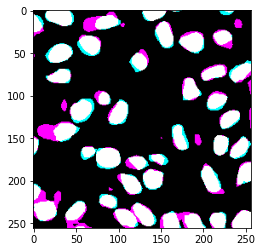

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/weights+vis/FPN/Segmentation/Autoencoder/MoNuSeg/FPN_best_AJI_0.612_F1_0.802.pth"))

# get predictions
preds = model(images).softmax(dim=1).argmax(dim=1)
preds = preds.detach().cpu().numpy()
one_pred= preds[4]
one_mask= sample["mask"][4].detach().cpu().numpy()
%matplotlib inline 
#plt.imshow(one_mask, cmap='gray')
GT1=one_pred.astype('uint8') *255
P1=one_mask.astype('uint8') *255


zero=np.zeros(GT1.shape,'uint8')
GT1=cv2.merge([GT1,zero,GT1])
P1=cv2.merge([zero,P1,P1])

mixed=GT1+P1
plt.imshow(mixed)


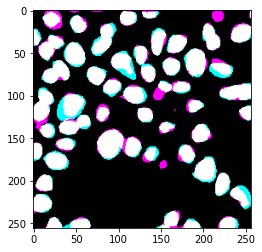

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/weights+vis/FPN/Segmentation/Autoencoder/MoNuSeg/FPN_best_AJI_0.612_F1_0.802.pth"))

# get predictions
preds = model(images).softmax(dim=1).argmax(dim=1)
preds = preds.detach().cpu().numpy()
one_pred= preds[10]
one_mask= sample["mask"][10].detach().cpu().numpy()
%matplotlib inline 
#plt.imshow(one_mask, cmap='gray')
GT1=one_pred.astype('uint8') *255
P1=one_mask.astype('uint8') *255


zero=np.zeros(GT1.shape,'uint8')
GT1=cv2.merge([GT1,zero,GT1])
P1=cv2.merge([zero,P1,P1])

mixed2=GT1+P1
plt.imshow(mixed2)

In [ ]:
cv2.imwrite("/content/drive/MyDrive/weights+vis/FPN/Segmentation/basic/mixed_2_Auto.png", mixed2[:,:,::-1] )

True

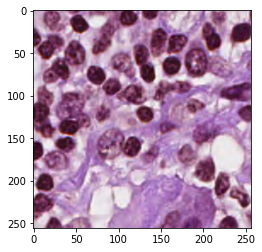

In [ ]:
plt.imshow(sample["image"][10].detach().cpu().numpy().transpose(1,2,0))

In [ ]:
cv2.imwrite("/content/drive/MyDrive/weights+vis/FPN/Segmentation/basic/Mo_vis/mixed_2_original.png", sample["image"][10].detach().cpu().numpy().transpose(1,2,0) )

True

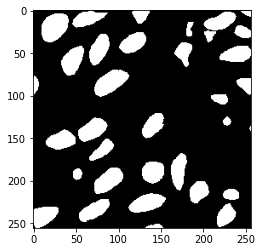

In [ ]:
GT=sample['mask'].detach().cpu().numpy()
P=preds.detach().cpu().numpy()
np.unique(GT)

plt.imshow(GT[0],cmap='gray')

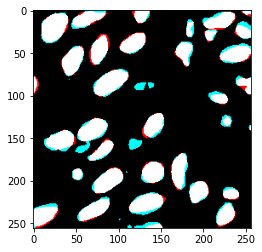

In [ ]:
image=images.detach().cpu().numpy()[0].transpose(1,2,0)
GT1=GT[0].astype('uint8') *255
P1=P[0].astype('uint8') *255


zero=np.zeros(GT1.shape,'uint8')
GT1=cv2.merge([GT1,zero,zero])
P1=cv2.merge([zero,P1,P1])

mixed=GT1+P1

#plt.imshow(image)
#plt.imshow(GT1)
#plt.imshow(P1)
plt.imshow(mixed)

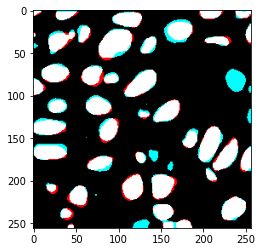

In [ ]:
image=images.detach().cpu().numpy()[2].transpose(1,2,0)
GT1=GT[2].astype('uint8') *255
P1=P[2].astype('uint8') *255


zero=np.zeros(GT1.shape,'uint8')
GT1=cv2.merge([GT1,zero,zero])
P1=cv2.merge([zero,P1,P1])

mixed=GT1+P1

#plt.imshow(image)
#plt.imshow(GT1,cmap='gray')
#plt.imshow(P1)
plt.imshow(mixed)

In [ ]:
# define soft-Jaccard loss
class SoftJaccardLoss(nn.Module):
    """
        Implementation of the Soft-Jaccard Loss function.

        Arguments:
            num_classes (int): number of classes.
            eps (float): value of the floating point epsilon.
    """
    def __init__(self, num_classes, eps=1e-5):
        super().__init__()
        # init fields
        self.num_classes = num_classes
        self.eps = eps

    # define forward pass
    def forward(self, pred_logits, targets):
        """
            Compute Soft-Jaccard Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W). targets (torch.LongTensor): tensor of ground-truth labels. 
                The shape of the tensor is (B, H, W).
        """
        # get predictions from logits
        preds = pred_logits.softmax(dim=1)
        loss = 0
        # iterate over all classes
        for cls in range(self.num_classes):
            # get ground truth for the current class
            target = (targets == cls).float()

            # get prediction for the current class
            pred = preds[:, cls]

            # calculate intersection of predictions and targets
            intersection = (pred * target).sum()

            # compute iou
            iou = (intersection + self.eps) / (pred.sum() + target.sum() - intersection + self.eps)

            # compute negative logarithm from the obtained dice coefficient
            loss = loss - iou.log()

        # get mean loss by class value
        loss = loss / self.num_classes

        return loss

## <font style="color:green">4.3. Implementation of the Focal Loss</font>

Focal loss is designed to:

- assign more weights on hard, easily-misclassified examples
- down-weight easy examples

It is helpful for class-disbalanced problems, where objects of one class appear more often than  others, like the background class in semantic segmentation. Let's implement it.

In [ ]:
# define Focal loss
class FocalLoss(nn.Module):
    """
        Implementation of the Focal Loss function.

        Arguments:
            num_classes (int): number of classes.
                valid_labels: 0,..., num_classes - 1
                ignore_index: num_classes
            gamma (float): parameter which control slope of loss function.
    """
    def __init__(self, num_classes, gamma=2.0, ignore_indices=-1):
        super().__init__()
        # init fields
        self.num_classes = num_classes
        self.gamma = gamma
        self.loss_fn = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_indices)

    # define forward pass
    def forward(self, pred_logits, target):
        """
            Compute Focal Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W).
                targets (torch.LongTensor): tensor of ground-truth labels. The shape of the tensor is 
                (B, H, W).
        """
        loss_ce = self.loss_fn(pred_logits, target)
        loss_focal = (1.0 - loss_ce.mul(-1).exp()).pow(self.gamma) * loss_ce
        return loss_focal.mean()

## <font style="color:green">4.4. Implementation of the Multi-Objective Loss Function</font>

Implement the target loss function as a combination of `Soft-Jaccard` and `Focal Loss`, which we will call
`Semantic Segmentation loss`.

In [ ]:
# define semantic segmentation loss
class SemanticSegmentationLoss(nn.Module):
    """
        Implementation of the multi-objective loss function for semantic segmentation.

        Arguments:
            num_classes (int): number of classes.
            jaccard_alpha (float): weight of the SoftJaccardLoss
    """
    def __init__(self, num_classes, jaccard_alpha=0.9, ignore_indices=-1):
        super().__init__()
        # init fields
        self.jaccard_alpha = jaccard_alpha
        self.jaccard = SoftJaccardLoss(num_classes)
        self.focal = FocalLoss(num_classes=num_classes, ignore_indices=ignore_indices)

    # define forward pass
    def forward(self, pred_logits, target):
        """
            Compute Focal Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W). targets (torch.LongTensor): tensor of ground-truth labels. 
                The shape of the tensor is (B, H, W).
        """
        # our loss is a weighted sum of two losses
        jaccard_loss = self.jaccard_alpha * self.jaccard(pred_logits, target)
        focal_loss = self.focal(pred_logits, target)
        loss = jaccard_loss + focal_loss
        return loss

## <font style="color:green">4.5. Train the Model With SoftJaccardLoss + FocalLoss</font>

How good was our implemented loss? Check out by running the same training with it.

In [ ]:
# define experiment with semantic segmentation loss
class ExperimentWithSemanticSegmentationLoss(Experiment):
    def __init__(self, *args, **kwargs):
        # init fields
        super().__init__(*args, **kwargs)
        num_classes = self.loader_test.dataset.get_num_classes()
        self.loss_fn = SemanticSegmentationLoss(num_classes=num_classes, ignore_indices=num_classes)

Hello1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

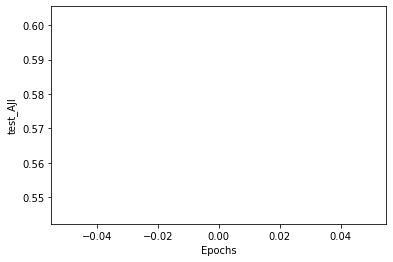

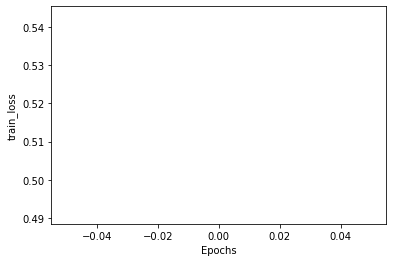

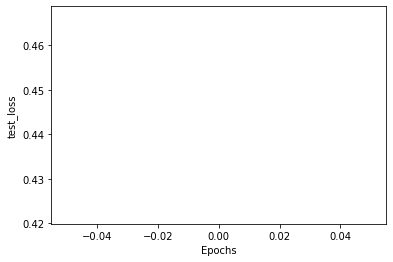

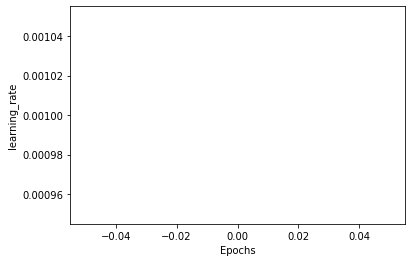

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
# create and run the experiment
semseg_loss_experiment = ExperimentWithSemanticSegmentationLoss(dataloader_config=dataloader_config)
semseg_loss_experiment_metrics = semseg_loss_experiment.run(trainer_config)

Let's plot test and train loss curves. Also, plot the test accuracy curve. It is quite evident that our multi-objective loss function provides slightly-better results.

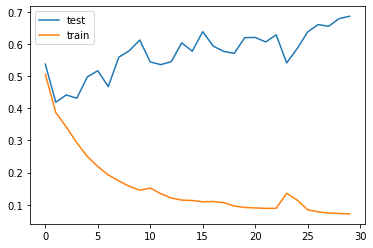

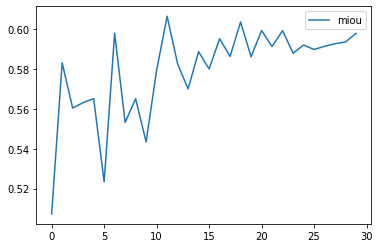

In [ ]:
# create new figure
plt.figure()
plt.plot(semseg_loss_experiment_metrics["test_loss"], label="test")
plt.plot(semseg_loss_experiment_metrics["train_loss"], label="train")
plt.legend()
plt.show()

# create new figure
plt.figure()
plt.plot([metric['AJI'] for metric in semseg_loss_experiment_metrics["test_metric"]], label="miou")
plt.legend()
plt.show()

Visualize a few test samples and predictions from the network to see how our predictions look.

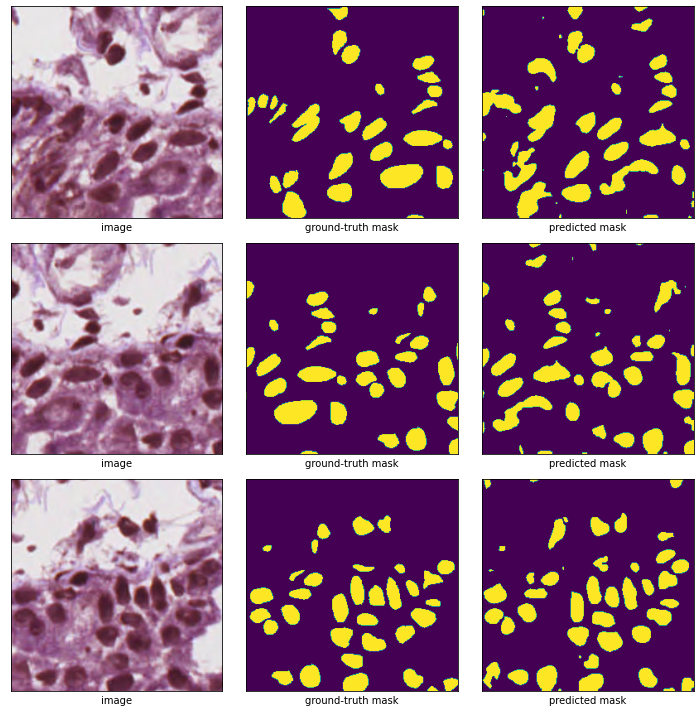

In [ ]:
# get test samples
sample = next(iter(semseg_loss_experiment.loader_test))
# get device to run the training on
device = torch.device(trainer_config.device)
# put images on the chosen device
images = sample["image"].to(device)
images=images.float()

# get predictions
preds = semseg_loss_experiment.model(images).softmax(dim=1).argmax(dim=1)
# visualize the results
draw_semantic_segmentation_batch(images, sample["mask"], preds)